Copyright (c) Meta Platforms, Inc. and affiliates.
This software may be used and distributed according to the terms of the Llama 2 Community License Agreement.

<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/quickstart/finetuning/quickstart_peft_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PEFT Finetuning Quick Start Notebook

This notebook shows how to train a Meta Llama 3 model on a single GPU (e.g. A10 with 24GB) using int8 quantization and LoRA finetuning.

**_Note:_** To run this notebook on a machine with less than 24GB VRAM (e.g. T4 with 16GB) the context length of the training dataset needs to be adapted.
We do this based on the available VRAM during execution.
If you run into OOM issues try to further lower the value of train_config.context_length.

# v3

바뀐점
- 전처리 과정에 \n\n\n 이렇게 연속된 개행문자가 들어간 경우 \n 하나로 바꾸도록 만듬.
- hyperparameter 수정. 
  - gradient_accumulation_steps = 4
  - num_epochs = 2
  - context_length = 512
- 입력 형식에서 plot_parameter 제거

In [1]:
# conda create -n ladlm_v1 python=3.11
# !conda install -y pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [2]:
# uncomment if running from Colab T4
# !pip install llama-recipes ipywidgets

In [3]:
# !pip install huggingface_hub

In [4]:
# from huggingface_hub import login
# login() 

### Step 1: Load the model

Setup training configuration and load the model and tokenizer.

In [5]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [6]:
import torch
from transformers import MllamaForConditionalGeneration, AutoTokenizer, AutoProcessor
from llama_recipes.configs import train_config as TRAIN_CONFIG

train_config = TRAIN_CONFIG()
train_config.model_name = "meta-llama/Llama-3.2-11B-Vision-Instruct"
train_config.num_epochs = 1
train_config.run_validation = False
train_config.gradient_accumulation_steps = 4
train_config.batch_size_training = 1
train_config.lr = 3e-4
train_config.use_fast_kernels = True
train_config.use_fp16 = True
train_config.context_length = 512 if torch.cuda.get_device_properties(0).total_memory < 16e9 else 1024 # T4 16GB or A10 24GB
train_config.batching_strategy = "packing"
train_config.output_dir = "ladlm_function_based_dataset_v1"
train_config.use_peft = True

from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)


model = MllamaForConditionalGeneration.from_pretrained(
            train_config.model_name,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.float16,
        )
processor = AutoProcessor.from_pretrained(train_config.model_name)

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

### Step 2: Check base model

Run the base model on an example input:

We can see that the base model only repeats the conversation.

### Step 3: Load the preprocessed dataset

We load and preprocess the samsum dataset which consists of curated pairs of dialogs and their summarization:

In [7]:
import copy
import itertools
from datasets import load_from_disk, Dataset
from PIL import Image
import torch
from torch.utils.data import DataLoader
import numpy as np
import os

# Assuming you have a processor compatible with Llama 3.2 Vision
# Replace `YourProcessor` with the actual processor class you're using

# Helper Functions
def check_header(targets, seq):
    """
    Check if any 3-token sequence in `seq` matches any target in `targets`.
    """
    for i in range(len(seq) - 2):
        if seq[i:i + 3] in targets:
            return True
    return False

def replace_target(target, seq):
    """
    Replace occurrences of `target` in `seq` with -100.
    """
    for i in range(len(seq) - 2):
        if seq[i:i + 3] == target:
            seq[i], seq[i + 1], seq[i + 2] = -100, -100, -100
    return seq

def tokenize_dialogs(dialogs, images, processor):
    """
    Tokenize the dialogs and images using the provided processor.
    Masks certain tokens as specified.
    """
    text_prompt = processor.apply_chat_template(dialogs)
    batch = processor(
        images=images,
        text=text_prompt,
        padding=True,
        return_tensors="pt"
    )
    label_list = []
    for i in range(len(batch["input_ids"])):
        dialog_tokens = batch["input_ids"][i].tolist()
        labels = copy.copy(dialog_tokens)
        eot_indices = [idx for idx, n in enumerate(labels) if n == 128009]
        last_idx = 0
        # Define prompt header sequences
        prompt_header_seqs = [
            [128006, 9125, 128007],  # <|start_header_id|>system<|end_header_id|>
            [128006, 882, 128007]    # <|start_header_id|>user<|end_header_id|>
        ]
        for idx in eot_indices:
            current_seq = labels[last_idx:idx + 1]
            if check_header(prompt_header_seqs, current_seq):
                # Mask the prompt header sequence
                labels[last_idx:idx + 1] = [-100] * (idx - last_idx + 1)
            else:
                last_idx = idx + 1
        # Mask assistant header prompt <|start_header_id|>assistant<|end_header_id|>
        assistant_header_seq = [128006, 78191, 128007]
        labels = replace_target(assistant_header_seq, labels)
        # Mask padding tokens and image tokens (128256)
        labels = [
            -100 if (token == processor.tokenizer.pad_token_id or token == 128256) else token
            for token in labels
        ]
        label_list.append(labels)
    batch["labels"] = torch.tensor(label_list)
    return batch

# Custom Dataset Loading Function
def get_custom_dataset(dataset_config, processor, split='train', split_ratio=0.9):
    """
    Load and preprocess the custom dataset.
    """
    # Replace with the actual path or identifier of your dataset
    dataset_path = '../../augmentation/datasets/ladlm_function_based_dataset'  # Adjust this path if your dataset is saved elsewhere
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"The dataset at '{dataset_path}' does not exist.")

    dataset = load_from_disk(dataset_path)
    # dataset = dataset_dict['train']

    # Optionally select a subset for quick testing
    # Remove or adjust the following line to use the full dataset
    # dataset = dataset.select(range(200))  # Example: select first 200 samples

    # Split the dataset
    train_test_split = dataset.train_test_split(test_size=1 - split_ratio, shuffle=True, seed=42)
    return train_test_split[split]

# Custom Data Collator
class CustomDataCollator:
    def __init__(self, processor):
        self.processor = processor
        self.processor.tokenizer.padding_side = "right"  # Ensure padding on the right

    def __call__(self, samples):
        dialogs, images = [], []
        for sample in samples:
            file_name = sample['file_name']

            # Extract and convert images
            # spectrogram_with_axes = sample['spectrogram_with_axes'].convert("RGB") # we can use this?
            spectrogram_no_axes = sample['spectrogram_no_axes'].convert("RGB")
            
            # Optionally, choose which spectrogram to use
            image = spectrogram_no_axes

            # Extract other features
            function_based_explanation_spectrogram = sample['function_based_explanation_spectrogram']

            # Replace multiple newlines with a single newline
            # function_based_explanation_spectrogram = re.sub(r'\n+', '\n', function_based_explanation_spectrogram)

            # Create dialogs as per your specification
            dialog = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text",
                         "text": f"This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. "
                                 f"\spectrogram json:\n"}
                ]},
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": function_based_explanation_spectrogram}
                    ]
                }
            ]
            dialogs.append(dialog)  # Each sample has a list of dialog lists
            images.append([image])     # Processor expects a list of image lists

        # Tokenize the dialogs and images
        batch = tokenize_dialogs(dialogs, images, self.processor)
        return batch

# Function to Get Data Collator
def get_data_collator(processor):
    return CustomDataCollator(processor)



In [8]:
import re

def preprocess_dataset(dataset):
    """
    텍스트 필드에서 연속된 개행 문자를 단일 개행 문자로 변경.
    이미지 데이터는 수정하지 않음.
    """
    for sample in dataset:
        if 'explanation_about_spectrogram' in sample:
            sample['explanation_about_spectrogram'] = re.sub(r'\n+', '\n', sample['explanation_about_spectrogram'])
    return dataset


In [9]:
from torch.utils.data import DataLoader

# Train/Test 데이터셋 로드
train_dataset = get_custom_dataset(
    dataset_config=None,
    processor=processor,
    split="train",
    split_ratio=0.7
)

eval_dataset = get_custom_dataset(
    dataset_config=None,
    processor=processor,
    split="test",
    split_ratio=0.7
)

train_dataset = preprocess_dataset(train_dataset)
eval_dataset = preprocess_dataset(eval_dataset)

print(f"훈련 데이터셋의 개수: {len(train_dataset)}")
print(f"평가 데이터셋의 개수: {len(eval_dataset)}")

# Data Collator 생성
data_collator = get_data_collator(processor)

# DataLoader 생성
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=train_config.batch_size_training, 
    collate_fn=data_collator, 
    shuffle=True
)

eval_dataloader = DataLoader(
    eval_dataset, 
    batch_size=train_config.batch_size_training, 
    collate_fn=data_collator, 
    shuffle=False
)

print(f"Train DataLoader and Eval DataLoader ready!")



훈련 데이터셋의 개수: 69
평가 데이터셋의 개수: 31
Train DataLoader and Eval DataLoader ready!


In [10]:
# !pip install librosa

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

def inference_vllm(sample, max_token=512):
    # 첫 번째 샘플의 이미지와 텍스트 추출
    file_name = sample['file_name']

    spectrogram_with_axes = sample['spectrogram_with_axes'].convert("RGB")
    spectrogram_no_axes = sample['spectrogram_no_axes'].convert("RGB")

    function_based_explanation_spectrogram = sample['function_based_explanation_spectrogram']

    messages = [
        [
            {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text",
                         "text": f"This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. "
                                 f"\spectrogram json:\n"}
            ]},
        ]
    ]

    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        spectrogram_no_axes,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(model.device)

    # # 입력을 모델이 있는 디바이스로 이동
    # inputs = {key: value.to(model.device) for key, value in inputs.items()}

    # 인퍼런스 수행
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_token)

    print(processor.decode(output[0]))
    plt.imshow(spectrogram_with_axes)
    plt.axis('off')
    plt.show()

    return processor.decode(output[0])


In [12]:
# inference_vllm(train_dataset[0])

### Step 4: Prepare model for PEFT

Let's prepare the model for Parameter Efficient Fine Tuning (PEFT):

In [13]:
from peft import get_peft_model, prepare_model_for_kbit_training, LoraConfig
from dataclasses import asdict
from llama_recipes.configs import lora_config as LORA_CONFIG

lora_config = LORA_CONFIG()
lora_config.r = 8
lora_config.lora_alpha = 32
lora_dropout: float=0.02

peft_config = LoraConfig(**asdict(lora_config))

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

### Step 5: Fine tune the model

Here, we fine tune the model for a single epoch.

In [14]:
import torch.optim as optim
from llama_recipes.utils.train_utils import train
from torch.optim.lr_scheduler import StepLR

model.train()

optimizer = optim.AdamW(
            model.parameters(),
            lr=train_config.lr,
            weight_decay=train_config.weight_decay,
        )
scheduler = StepLR(optimizer, step_size=1, gamma=train_config.gamma)

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Start the training process
results = train(
    model,
    train_dataloader,
    eval_dataloader,
    processor, # tokenizor 대채
    optimizer,
    scheduler,
    train_config.gradient_accumulation_steps,
    train_config,
    None,
    None,
    None,
    wandb_run=None,
)

/home/uturtle/anaconda3/envs/ladlm_function_based/lib/python3.11/site-packages/llama_recipes/model_checkpointing/checkpoint_handler.py:17: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoint` instead
  from torch.distributed._shard.checkpoint import (
/home/uturtle/anaconda3/envs/ladlm_function_based/lib/python3.11/site-packages/llama_recipes/utils/train_utils.py:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/uturtle/anaconda3/envs/ladlm_function_based/lib/python3.11/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Starting epoch 0/1
train_config.max_train_step: 0


Training Epoch: 1:   0%|          | 0/17 [00:00<?, ?it/s]/home/uturtle/anaconda3/envs/ladlm_function_based/lib/python3.11/site-packages/llama_recipes/utils/train_utils.py:152: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/uturtle/anaconda3/envs/ladlm_function_based/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/uturtle/anaconda3/envs/ladlm_function_based/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Grad

Max CUDA memory allocated was 10 GB
Max CUDA memory reserved was 11 GB
Peak active CUDA memory was 10 GB
CUDA Malloc retries : 46
CPU Total Peak Memory consumed during the train (max): 4 GB
Epoch 1: train_perplexity=1.4949, train_epoch_loss=0.4020, epoch time 143.84233193501132s


### Step 6:
Save model checkpoint

In [15]:
model.save_pretrained(train_config.output_dir)

### Step 7:
Try the fine tuned model on the same example again to see the learning progress:

In [16]:
import torch
from PIL import Image

# 모델을 평가 모드로 전환
model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MllamaForConditionalGeneration(
      (vision_model): MllamaVisionModel(
        (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
        (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
          (tile_embedding): Embedding(9, 8197120)
        )
        (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
          (embedding): Embedding(9, 5120)
        )
        (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
          (embedding): Embedding(9, 5120)
        )
        (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (transformer): MllamaVisionEncoder(
          (layers): ModuleList(
            (0-31): 32 x MllamaVisionEncoderLayer(
              (self_attn): MllamaVisionSdpaAttention(
               

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. \spectrogram json:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{"spectrogram_base":{"sample_rate":16000,"n_fft":256,"hop_length":256,"noise_strength":3.013,"noise_type":"normal","noise_params":{"mean":0.0,"std":1.0,"seed":122419859}},"shapes":[{"type":"vertical_range","parameters":{"center_freq":5.355,"thickness":2.047,"strength_dB":19.819}}],"patterns":[]}<|eot_id|>


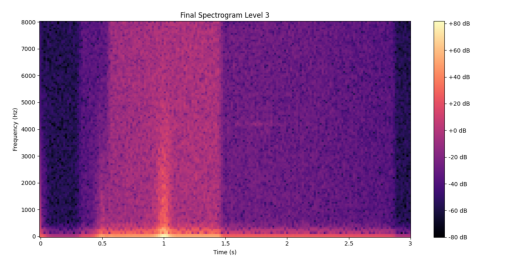

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. \spectrogram json:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{"spectrogram_base":{"sample_rate":16000,"n_fft":256,"hop_length":256,"noise_strength":6.93,"noise_type":"normal","noise_params":{"mean":0.0,"std":1.0,"seed":101294225}},"shapes":[{"type":"vertical_range_dba","parameters":{"center_freq":3409.743,"thickness":0.003,"radius":3.0,"distribution":"gaussian","distribution_params":{"sigma":0.5}}},{"type":"horizontal_spike","parameters":{"center_time":0.0,"thickness":1,"radius":1000.0}}],"patterns":[{"type":"random","parameters":{"shape_name":"horizontal_spike","shape_params":{"center_time":1.0,"thickness":1,"radius":1000.0},"n":5,"freq_range":[0,8000.0],"time_range":[0,3.0]}}]}<|eot_id|>


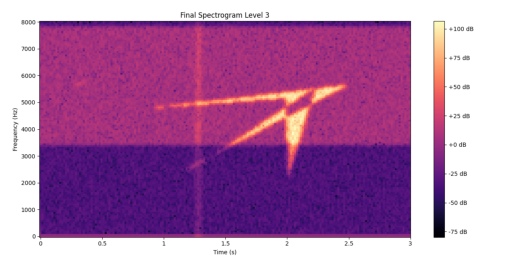

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>This is an image extracted using the Short-Time Fourier Transform (STFT) with librosa. \spectrogram json:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{"spectrogram_base":{"sample_rate":16000,"n_fft":256,"hop_length":256,"noise_strength":7.245,"noise_type":"normal","noise_params":{"mean":0.0,"std":1.0,"seed":106493859}},"shapes":[{"type":"vertical_spike","parameters":{"center_freq":5507.253,"center_time":1.044,"radius_freq":2.509,"radius_time":0.053,"strength_dB":29.475}}],"patterns":[]}<|eot_id|>


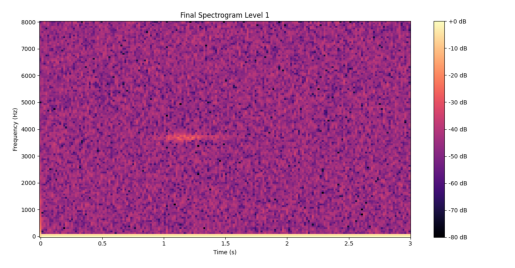

In [17]:
from PIL import Image
import matplotlib.pyplot as plt

for i in range(3):
    inference_vllm(eval_dataset[i])

### Step 8 make compare table


In [18]:
# import os
# from PIL import Image as PILImage
# from openpyxl import Workbook
# from openpyxl.drawing.image import Image as ExcelImage
# import matplotlib.pyplot as plt
# import torch

# # 엑셀 파일 생성
# output_excel = f"{train_config.output_dir}_compare_table.xlsx"
# wb = Workbook()
# ws = wb.active
# ws.title = "Compare Table"

# # 열 헤더 설정
# headers = [
#     "File Name", "Domain", "Type", "Machine Type",
#     "Explanation About Spectrogram", "Generated Text", "Spectrogram Image"
# ]
# ws.append(headers)

# # 평가 데이터셋 처리 루프
# for i, sample in enumerate(eval_dataset):
#     generated_text = inference_vllm(sample)

#     if "<|start_header_id|>assistant<|end_header_id|>" in generated_text:
#         generated_text = generated_text.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
#     print(f"recreated: {generated_text}")

#     file_name = sample['file_name']

#     linear_spectrogram_with_axes_image = sample['linear_spectrogram_with_axes']['image'].convert("RGB")
#     # linear_spectrogram_no_axes_image = sample['linear_spectrogram_no_axes']['image'].convert("RGB")

#     # librosa_parameters = sample['linear_spectrogram_no_axes']['librosa_parameters']
#     # plot_parameters = sample['linear_spectrogram_no_axes']['plot_parameters']

#     domain = sample['domain']              
#     type_ = sample['type']                  
#     machineType = sample['machineType']    
#     explanation_about_spectrogram = sample['explanation_about_spectrogram']

#     # 플롯된 이미지 저장
#     img_path = f"temp_image_{i}.png"
#     plt.imshow(linear_spectrogram_with_axes_image)
#     plt.axis('off')
#     plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
#     plt.close()

#     # 이미지 크기 확인
#     with PILImage.open(img_path) as img:
#         img_width, img_height = img.size

#     # 엑셀 셀 크기 조정
#     cell_width = img_width / 7  # 열 너비는 픽셀 크기의 1/7
#     cell_height = img_height * 0.75  # 행 높이는 픽셀 크기의 0.75

#     # 셀 크기 조정
#     ws.column_dimensions['G'].width = max(ws.column_dimensions['G'].width or 0, cell_width)
#     ws.row_dimensions[i + 2].height = cell_height

#     # 엑셀에 데이터 추가
#     ws.append([file_name, domain, type_, machineType, explanation_about_spectrogram, generated_text])

#     # 이미지 삽입
#     img = ExcelImage(img_path)
#     img.anchor = f"G{i + 2}"  # 엑셀 셀 위치 지정 (헤더가 1줄 차지하므로 2부터 시작)
#     ws.add_image(img)

# # 엑셀 저장
# wb.save(output_excel)

# # 임시 이미지 파일 삭제
# for i in range(len(eval_dataset)):
#     img_path = f"temp_image_{i}.png"
#     if os.path.exists(img_path):
#         os.remove(img_path)

# print(f"Evaluation results saved to {output_excel}")


### 추가할만한 부분?


- 데이터 셋이 너무 작다.
- 데이터셋은 대화라기 보다 분석이기 때문에 \n 로 끊기는 구간이 많다. 이것을 하나의 문장이나 문단으로 꾸미고 최종 결론까지 적어 dataset의 퀄리티를 향상시키면 좋겠다고 생각했다.
  - 현재 보면 단문으로 끊기는 문장이 생각보다 많다. 문장이 더 생성되지 않아 생기는 문제가 제일 크다는 점을 보아 데이터셋 output의 구체적인 foramt도 정해두는게 좋겠다 생각했다.
- spectrogram을 분석할때는 가로선형패턴과 spike, 그리고 어느 대역과 구간에 에너지 분포가 얼마나 강한지, 그리고 주기적인지 비주기적인지를 구체적으로 명시해야한다. 
  - 주제(가로선형 패턴 존재 위치, 스파이크 존재 여부, ) 별로 나누에서 있음 없음을 제대로 명시한다면 더 좋은 결과를 만들 것이다.
  - 특히 질문을 나누어서 학습시킨뒤 마지막에 최종 결론을 내리는 부분을 학습시킨다면 성능이 더 좋아질 수 있을 것이라 예측한다. 
    - 쉬운 문제에서 어려운 문제순으로 학습시키면 더욱 좋은 결과가 나온다: 
      - Reference
        - [A Survey of Large Language Models](https://arxiv.org/abs/2303.18223)
          - 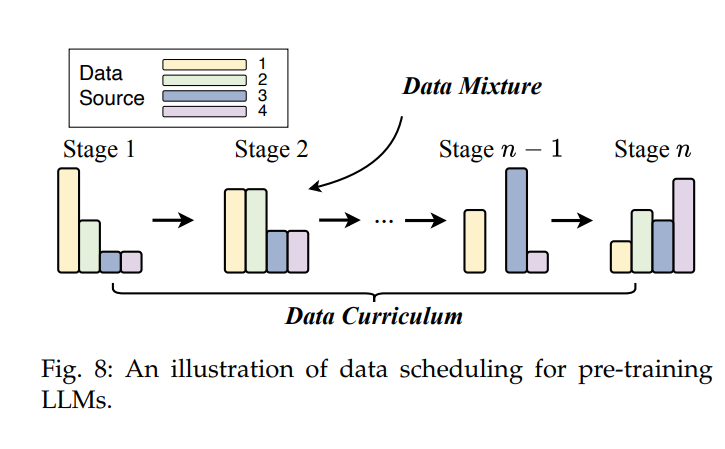
        - [Curriculum_learning](https://www.researchgate.net/publication/221344862_Curriculum_learning)

**현재 상황**?: 다른 다양한 데이터를 10~20개 정도만 제대로 학습시켜서 inference한다면 전체 데이터에 대한 eda가 훨씬 수월해질 수 있다는 가망성은 보인다. 하지만 아직 멀었다.

# 엑셀만들때...

- 다음에 엑셀 만들떄는 소리 같이 들을 수 있는것도 실장할 수 있으면 실장해야지